In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [2]:
#lecture de l'image
image =cv.imread('image2.png',0)

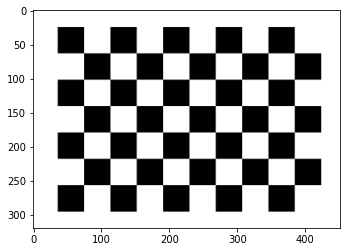

In [3]:
plt.imshow(image,cmap='gray')

# Detection de points avec le detecteur MORAVEC

Définition de paramètres

In [4]:
image[50,0:200]

array([255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255,  74,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 173,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 191, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
       255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 25

In [5]:
# paramétres de MORAVEC
S= 2  # Seuil
F= 3  # Taille de la fenêtre
U= [[1,0],[1,1],[0,1],[-1,1],[-1,0],[-1,-1],[0,-1],[1,-1]]# Déplacements

Calcul de la carte de coins (cornerness map)

In [6]:
image.shape

(320, 452)

In [7]:
def moravec(image,S,F,U):
    image_hat = np.zeros(image.shape)#image pour retourner
    fenetre = initFenetre(F)
    len_V = int(np.sqrt((len(U)+1)))
    V = np.zeros((len_V,len_V),dtype=np.float64)# init de vecteur V
    for i in range(2,image.shape[0]-2):#hauteur

        for j in range(2, image.shape[1]-2):#largeur
      #V = np.zeros((len_V,len_V),dtype=np.float64)
            for deplacementUV in U:
        
                u,v = deplacementUV[0],deplacementUV[1]
                if(not(u==0 and v==0)):
          
                    uu,vv = Translate(V,u,v)
                    V[uu,vv]=0
          
                    for row in fenetre:
                        for deplacementAB in row:
                            a,b = deplacementAB[0], deplacementAB[1]
                            uu,vv = Translate(V,u,v)
                            i+u+a,j+v+b
                            V[uu,vv]=V[uu,vv]+ np.power((image[i+u+a][j+v+b]-image[i+a][j+b]),2)
    
            cx,cy = uu,vv = Translate(V,0,0)
            V[cx,cy]= np.max(V)# on ne considere pas le poin 0,0 de u,v car il est pas inclus dans l algo
            C = np.min(V)
            if(C>=S):
                image_hat[i,j]=1

    return image_hat

def Translate(V,u,v):
    hash_map = {-1:0,0:1,1:2}
    return hash_map[u],hash_map[v]
def initFenetre(F):
    Delta = int((F-1)/2)
    ar = [[e,a] for e in range(-Delta,Delta+1,1) for a in range(-Delta,Delta+1,1)]
    return  np.asarray(ar).reshape(F,F,2)



In [8]:
img2 = moravec(image,S,F,U)




<ipython-input-7-a3cf89b17ce9>:23: RuntimeWarning: overflow encountered in ubyte_scalars
  V[uu,vv]=V[uu,vv]+ np.power((image[i+u+a][j+v+b]-image[i+a][j+b]),2)


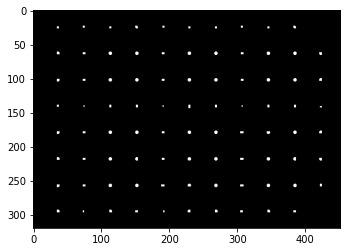

In [9]:
plt.imshow(img2,cmap='gray')

In [10]:
a,b=np.where(img2==1)

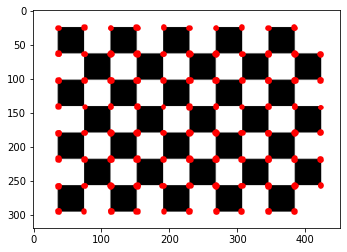

In [11]:
plt.figure()
plt.imshow(image,cmap='gray')
plt.plot(b,a,'r.')

# Descripteurs Harris
D'abord calculer les valeurs et vecteurs propres comme vu en TD, puis appliquer l'agorithme de Harris

In [12]:
A= [[-1,2,0],[0,3,4],[0,0,7]]
B=[[-1,2,2],[2,2,-1],[1,-2,1]]
val1, vec1 = LA.eig(A)
val2, vec2 = LA.eig(B)

In [13]:
print(val1,'\n', vec1,'\n',val2,'\n',vec2)

[-1.  3.  7.] 
 [[1.         0.4472136  0.17407766]
 [0.         0.89442719 0.69631062]
 [0.         0.         0.69631062]] 
 [-3.  2.  3.] 
 [[-8.16496581e-01  4.36435780e-01 -5.61733355e-16]
 [ 4.08248290e-01 -2.18217890e-01 -7.07106781e-01]
 [ 4.08248290e-01  8.72871561e-01  7.07106781e-01]]


# Detection de points avec HARRIS
- appliquer les étapes vues en TD
- pour chaque point (x,y) de l'image, determiner si c'est un point d'interêt ou pas en prennant une fenêtre 3x3 entourant x,y

méthode utilisée :

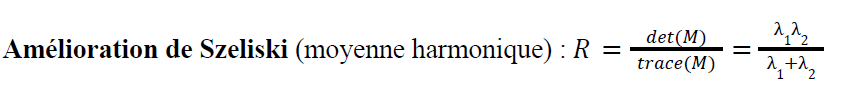

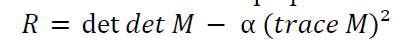

sigma = 0.2

In [14]:
from scipy import signal as sig
import numpy as np
from scipy.ndimage import  gaussian_filter

def Hariss(image,method='classic',sigM=0.2):
  #Dérivatoin x-----> y---->
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Ix = sig.convolve2d(image, kernel_x, mode='same')
    Iy = sig.convolve2d(image, kernel_y, mode='same')
  ##### fin de dérivation 


  # les quatres images et la convolution gaussian: 
    Ixx = gaussian_filter(Ix**2, sigma=sigM)
    Ixy = gaussian_filter(Iy*Ix, sigma=sigM)
    Iyy = gaussian_filter(Iy**2, sigma=sigM)

    im_sortie = np.zeros(image.shape)
    alpha = 0.04 
    R = np.zeros(image.shape)
  #calcule de R:
    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
            M = np.array([[Ixx[i, j], Ixy[i, j]], [Ixy[i, j], Iyy[i, j]]], dtype=np.float64)
            if(method == 'Szeliski'):
                R[i, j] = np.linalg.det(M) / (np.power(np.trace(M), 2)) # good

            elif(method == 'classic'):
                R[i, j] = np.linalg.det(M) - alpha*(np.power(np.trace(M), 2))
    
  #seuillage : 
        U= [[1,0],[1,1],[0,1],[-1,1],[-1,0],[-1,-1],[0,-1],[1,-1]]# Déplacements

        for i in range(R.shape[0]):
            for j in range(R.shape[1]):
                if (R[i,j]> 0  ):# positive ?
                    for e in U:
                        if(R[i,j]> R[i+e[0],j+e[1]] ) :
                            im_sortie[i,j]=1 
    return im_sortie

#im_sortie = cv.dilate(im_sortie,None)




<ipython-input-14-4477032617f2>:27: RuntimeWarning: invalid value encountered in double_scalars
  R[i, j] = np.linalg.det(M) / (np.power(np.trace(M), 2)) # good


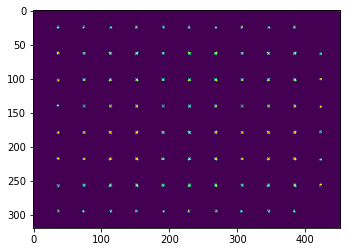

In [15]:
im_sortie_Szeliski = Hariss(image,method='Szeliski',sigM = 0.2)
plt.imshow(im_sortie_Szeliski)

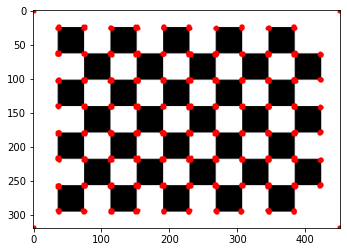

In [16]:
a,b=np.where(im_sortie_Szeliski==1)
plt.figure()
plt.imshow(image,cmap='gray')
plt.plot(b,a,'r.')

pour sigma = 0.1

<ipython-input-14-4477032617f2>:27: RuntimeWarning: invalid value encountered in double_scalars
  R[i, j] = np.linalg.det(M) / (np.power(np.trace(M), 2)) # good


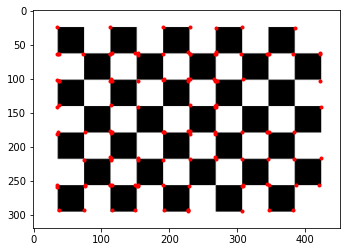

In [17]:
im_sortie_Szeliski = Hariss(image,method='Szeliski',sigM = 0.1)
a,b=np.where(im_sortie_Szeliski==1)
plt.figure()
plt.imshow(image,cmap='gray')
plt.plot(b,a,'r.')

comparer avec opencv

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


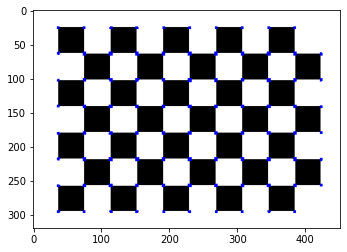

In [18]:
img=image.copy()
# Detecter les points avec Harris
dst = cv.cornerHarris(img,2,3,0.04)
# Dilater l'image pour mieux visualiser les points de coins
dst = cv.dilate(dst,None)
# Créer une image RVB
img2=np.zeros((img.shape[0],img.shape[1],3))
img2[:,:,0]=img
img2[:,:,1]=img
img2[:,:,2]=img
# Dessiner les points sur l'image RVB
img2[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(img2)